# Case study of 2021 MAM season over Ethiopia in CFSv2

In [19]:
import xarray as xr
from xarray.groupers import SeasonResampler
import xagg as xa
import xesmf as xe
import numpy as np
import pandas as pd 
import geopandas as gpd
import os
import glob
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
from cartopy import crs as ccrs
import cmocean
from dask.diagnostics import ProgressBar
from numba import jit as njit
from distributed import Client

from funcs_support import get_params,get_filepaths, utility_print, utility_save
from funcs_aux import get_landmask

dir_list = get_params()

In [20]:
client = Client()
display(client)

/home/kschwarz/.conda/envs/aa_thresh/lib/python3.13/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39841 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:39841/status,
Dashboard: http://127.0.0.1:39841/status,Workers: 8
Total threads: 48,Total memory: 503.37 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34633,Workers: 0
Dashboard: http://127.0.0.1:39841/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:35917,Total threads: 6
Dashboard: http://127.0.0.1:40931/status,Memory: 62.92 GiB
Nanny: tcp://127.0.0.1:33515,


In [21]:
# Get Ethiopian admin region boundaries
gdfs = {lev:gpd.read_file(f'{dir_list['aux']}geo_data/eth_admin_boundaries/eth_{lev}.shp')
        for lev in ['admin1','admin0']}
subset_params = {'lat':slice(0,18),'lon':slice(30,50)}

In [22]:

chunk_sizes = {'NCEP-CFSv2':20,
               'NCEP-CFSv2-ensmean':40,
               'GPCP':40,
               'CHIRPS':200}
def load_data(proc_source,data = 'raw',return_loadfn = False,chunk_sizes = chunk_sizes):
    if data == 'raw':
        df = get_filepaths(source_dir = 'raw').query('varname == "pr"')
        if proc_source == 'GPCP':
            #----- For GPCP ----- 
            df_tmp = df.query('model == "GPCP"')
            fn = df_tmp.iloc[0]['path']
            ds = xr.open_dataset(fn)
            
        elif proc_source == 'CHIRPS':
            #----- For CHIRPS ----- 
            df_tmp = df.query('model == "CHIRPS" and freq == "Amon"')
            fn = df_tmp.iloc[0]['path']
            ds = xr.open_dataset(fn,chunks = {'lat':chunk_sizes[proc_source],
                                              'lon':chunk_sizes[proc_source],'time':-1})
    
        elif proc_source == 'NCEP-CFSv2':
            df_tmp = df.query('model == "NCEP-CFSv2" and freq == "Amon" and filetype == "zarr"')
            fn = df_tmp.iloc[0]['path']
            ds = xr.open_zarr(fn).isel(lead=0)
        
        elif proc_source == 'NMME':
            #----- For NMME -----
            # Will require setting model explicilty in figure code
            # AND will require changing bootstrap code to only sample from non-nan chunks
            df_tmp = df.query('exp == "hindcasts"')
            ds = xr.concat([xr.open_dataset(row[1]['path'],chunks={'lat':20,'lon':50})
                            for row in df_tmp.iterrows()],
                           dim=pd.Index([row[1]['model'] for row in df_tmp.iterrows()],
                                                       name='model'),
                            join='outer')
    elif data == 'seasavg':
        df = get_filepaths(source_dir = 'proc').query('varname == "pr" and freq == "seasavg"')
        df_tmp = df.query(f'model == "{proc_source}"')
        fn = df_tmp.iloc[0]['path']
        if df_tmp.iloc[0]['filetype'] == 'zarr':
            ds = xr.open_zarr(fn)
            ds = ds.chunk({'lat':chunk_sizes[proc_source],
                                              'lon':chunk_sizes[proc_source]})
        else:
            ds = xr.open_dataset(fn)
    else:
        raise KeyError(f'`data` input {data} not supported')


    if return_loadfn:
        return ds,fn
    else:
        return ds

In [32]:
proc_source = 'CHIRPS'
#proc_source = 'NCEP-CFSv2-ensmean'
#proc_source = 'GPCP'
#-------------------------
# Get seasonal means
#-------------------------
dsm = load_data(proc_source,data = 'seasavg').sel(**subset_params).load()

In [33]:
# Load trigger thresholds for a given data product
threshs = xr.open_dataset(dir_list['tmp']+'pr-trigger-threshs_year_'+proc_source+'.zarr')
threshs = threshs.sel(**subset_params).load() # Small enough that we don't need dask for this really

In [34]:
# Merge together rainfall and trigger thresholds
dsm = xr.merge([dsm[['pr']],threshs],compat='no_conflicts')

In [35]:
# Get anomalies vs. mean rainfall and full-sample threshold 
dsm['pranom_vsmean'] = dsm.pr - dsm.pr.mean('year')
dsm['pranom_vsthresh'] = dsm.pr - dsm.pr.quantile(0.2,dim='year')

/home/kschwarz/.conda/envs/aa_thresh/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1617: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


In [36]:
if proc_source == 'NCEP-CFSv2':
    dsm = dsm.where(dsm!=0).mean('run')

In [37]:
# Aggregate data to Ethiopian ADM1 regions
wm = xa.pixel_overlaps(dsm,gdfs['admin1'])
with xa.set_options(impl='numba'):
    ds_agg = xa.aggregate(dsm,wm).to_dataset()

ds_agg = ds_agg.set_coords([v for v in ds_agg if ((v != 'pr') and (('thresh' not in v) and ('trigg' not in v)))])
ds_agg['poly_idx'] = ds_agg.adm1_name

creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!
adjusting grid... (this may happen because only a subset of pixels were used for aggregation for efficiency - i.e. [subset_bbox=True] in xa.pixel_overlaps())
grid adjustment successful
aggregating pr...


/home/kschwarz/.conda/envs/aa_thresh/lib/python3.13/site-packages/xagg/auxfuncs.py:167: SomeNanWarning: One or more grid cells in variable pr have inconsistent nans along the dimension(s) season, year (i.e., one or more grid cells are nan for some but not all coordinates of the dimension(s)). This means that grid cell weights will be different for different coordinates along season, year. The aggregation calculation may therefore be incorrect, since it aggregates over different grid cells for  the same polgyon for different coordinates of the dimension(s)season, year.
  warnings.warn('One or more grid cells in variable '+var+' have inconsistent nans along the dimension(s) '+
/home/kschwarz/.conda/envs/aa_thresh/lib/python3.13/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 100.05 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See 

aggregating threshmean...
aggregating triggiqr...
aggregating triggiqr_cv...
aggregating triggiqr_cv_log...
aggregating triggiqr_cv_meanpr...
aggregating triggthresh...


/home/kschwarz/.conda/envs/aa_thresh/lib/python3.13/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 2.11 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


aggregating pranom_vsmean...


/home/kschwarz/.conda/envs/aa_thresh/lib/python3.13/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 100.05 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


aggregating pranom_vsthresh...


/home/kschwarz/.conda/envs/aa_thresh/lib/python3.13/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 100.05 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


all variables aggregated to polygons!


/home/kschwarz/.conda/envs/aa_thresh/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1863: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)
/home/kschwarz/.conda/envs/aa_thresh/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1863: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)
/home/kschwarz/.conda/envs/aa_thresh/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1863: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)
/home/kschwarz/.conda/envs/aa_thresh/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1863: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)
/home/kschwarz/.conda/envs/aa_thresh/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1863: RuntimeW

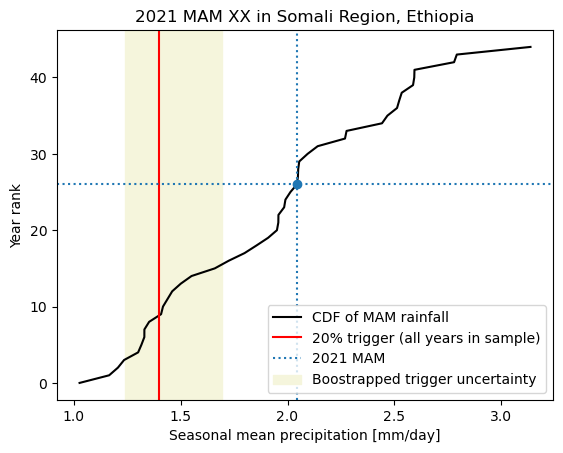

In [38]:
proc_params = {'poly_idx':'Somali','season':'MAM'}

ax = plt.subplot()

plot_data = ds_agg.sel(**proc_params)#.mean('run')

plt.plot(np.sort(plot_data.pr),
         np.arange(0,plot_data.sizes['year']),
         color='k',label='CDF of MAM rainfall')

ax.axvline(plot_data.pr.quantile(0.2),
           color='r',label='20% trigger (all years in sample)')

# Get location of test year
test_year = 2021
test_year_rain = plot_data.sel(year=test_year).pr
test_year_rank = np.argmax(np.sort(plot_data.pr.values) == (plot_data.sel(year=test_year).pr.values))

plt.plot(test_year_rain,
         test_year_rank,
        marker='o',color='tab:blue')
ax.axhline(test_year_rank,color='tab:blue',linestyle=':',label='2021 MAM')
ax.axvline(test_year_rain,color='tab:blue',linestyle=':')


# Plot uncertainty
ax.axvspan(ds_agg.sel(**proc_params).triggthresh.quantile(0.0),
           ds_agg.sel(**proc_params).triggthresh.quantile(1),
           color='beige',label='Boostrapped trigger uncertainty')

# Annotations
ax.set_xlabel('Seasonal mean precipitation [mm/day]')
ax.set_ylabel('Year rank')
ax.set_title('2021 MAM XX in Somali Region, Ethiopia')

ax.legend()

Text(0.5, 1.0, '')

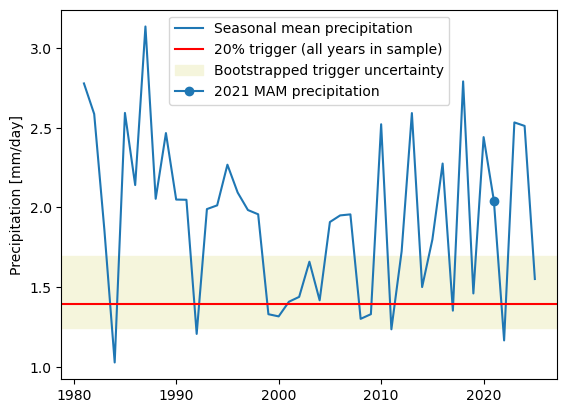

In [39]:
ax = plt.subplot()
plot_data.pr.plot(color='tab:blue',label='Seasonal mean precipitation')

ax.axhline(plot_data.pr.quantile(0.2),
           color='r',label='20% trigger (all years in sample)')
# Plot uncertainty
ax.axhspan(plot_data.triggthresh.quantile(0.0),
           plot_data.triggthresh.quantile(1),
           color='beige',label='Bootstrapped trigger uncertainty')

# Plot test year
test_year = 2021
test_year_rain = plot_data.sel(year=test_year).pr
plt.plot(test_year,test_year_rain,
        marker='o',color='tab:blue',label='2021 MAM precipitation')

ax.set_ylabel('Precipitation [mm/day]')
ax.set_xlabel('')

ax.legend()

ax.set_title('')



/home/kschwarz/projects/forecast_uncertainty/2. figures/case_study_somalireg_MAM_2021_CHIRPS.pdf saved!
/home/kschwarz/projects/forecast_uncertainty/2. figures/case_study_somalireg_MAM_2021_CHIRPS.png saved!


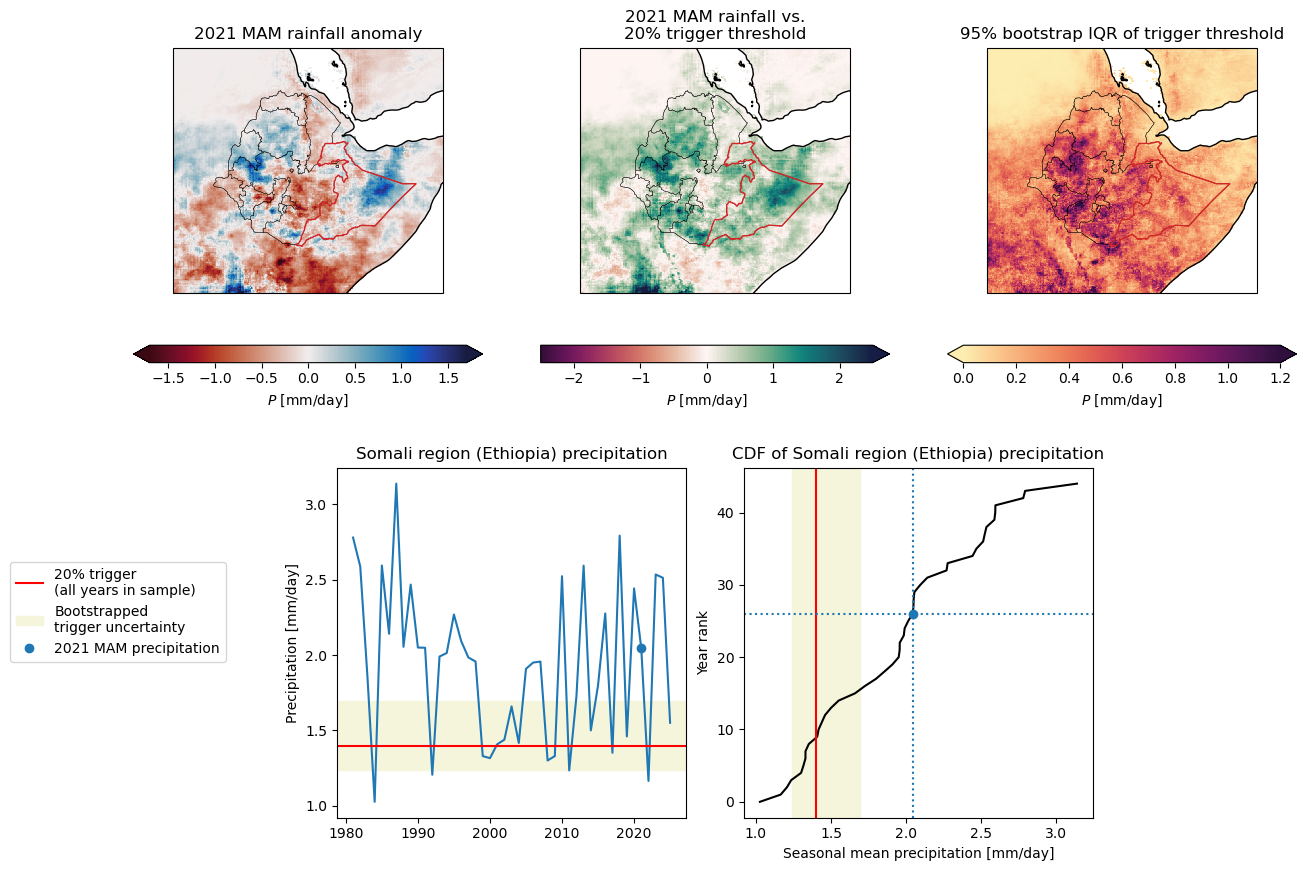

In [40]:
proc_params = {'poly_idx':'Somali','season':'MAM'}
test_year = 2021 # 1996 #2000 #2007 #2021
loc_str = 'Somali region (Ethiopia)'

save_fig = True
output_fn = f'{dir_list['figs']}case_study_somalireg_{proc_params['season']}_{test_year}_{proc_source}'


map_varlist = ['pranom_vsmean','pranom_vsthresh','triggiqr']


cbar_params = {'pranom_vsmean':{'cmap':cmocean.cm.balance_r,'vmin':-1.7,'vmax':1.7,'cbar_kwargs':{'label':'$P$ [mm/day]','location':'bottom'}},
               'pranom_vsthresh':{'cmap':cmocean.cm.curl_r,'vmin':-2.5,'vmax':2.5,'cbar_kwargs':{'label':'$P$ [mm/day]','location':'bottom'}},
               'triggiqr':{'cmap':cmocean.cm.matter,'vmin':0,'vmax':1.2,'cbar_kwargs':{'label':'$P$ [mm/day]','location':'bottom'}}}

titles = {'pranom_vsmean':f'{str(test_year)} {proc_params['season']} rainfall anomaly',
          'pranom_vsthresh':f'{str(test_year)} {proc_params['season']} rainfall vs.\n20% trigger threshold',
          'triggiqr':r'95% bootstrap IQR of trigger threshold'}

fig = plt.figure(figsize=(15,10))

gs = GridSpec(2, 6, wspace = 0.4)

#------------------------------------------------
# Maps
#------------------------------------------------

for plt_idx,var in enumerate(map_varlist):
    #ax = plt.subplot(1,len(map_varlist),plt_idx+1,projection=ccrs.PlateCarree())
    ax = fig.add_subplot(gs[0,(plt_idx*2):((plt_idx+1)*2)],projection=ccrs.PlateCarree())

    # Plot variable
    plot_data = dsm[var].sel(**subset_params,season=proc_params['season'])
    if 'year' in plot_data.sizes:
        plot_data = plot_data.sel(year=test_year) 
    plot_data.plot(**cbar_params[var],transform=ccrs.PlateCarree())

    # Add borders
    for adm_code,weight in zip(['admin1','admin0'],[0.25,0.3]):
        gdfs[adm_code].cx[subset_params['lon'],subset_params['lat']].plot(ax=ax,facecolor='none',edgecolor='k',
                                                           linestyle='-',linewidth=weight,
                                                           transform=ccrs.PlateCarree(),
                                                                         )
    # Highlight Somali region
    gdfs['admin1'].query(f'adm1_name=="{proc_params['poly_idx']}"').plot(ax=ax,facecolor='none',edgecolor='tab:red',
                                                   linestyle='-',linewidth=1,
                                                   transform=ccrs.PlateCarree())
    
    # Add coastlines
    ax.coastlines()

    # Annotate
    ax.set_title(titles[var])


#------------------------------------------------
# Time series graph
#------------------------------------------------
ax = fig.add_subplot(gs[1,1:3])

plot_data = ds_agg.sel(**proc_params)
plot_data.pr.plot(color='tab:blue'),#label='Seasonal mean precipitation')

ax.axhline(plot_data.pr.quantile(0.2),
           color='r',label='20% trigger\n(all years in sample)')
# Plot uncertainty
ax.axhspan(plot_data.triggthresh.quantile(0.0),
           plot_data.triggthresh.quantile(1),
           color='beige',label='Bootstrapped\ntrigger uncertainty')

# Plot test year
test_year_rain = plot_data.sel(year=test_year).pr
plt.plot(test_year,test_year_rain,
        marker='o',linestyle='none',color='tab:blue',
         label=f'{str(test_year)} {proc_params['season']} precipitation')

ax.set_ylabel('Precipitation [mm/day]')
ax.set_xlabel('')

ax.legend(bbox_to_anchor = (-0.3,0.75))

ax.set_title(f'{loc_str} precipitation')

#------------------------------------------------
# CDF graph
#------------------------------------------------

ax = fig.add_subplot(gs[1,3:5])

plot_data = ds_agg.sel(**proc_params)

plt.plot(np.sort(plot_data.pr),
         np.arange(0,plot_data.sizes['year']),
         color='k',label='CDF of rainfall')

ax.axvline(plot_data.pr.quantile(0.2),
           color='r',label='20% trigger (all years in sample)')

# Get location of test year
test_year_rain = plot_data.sel(year=test_year).pr
test_year_rank = np.argmax(np.sort(plot_data.pr.values) == (plot_data.sel(year=test_year).pr.values))

plt.plot(test_year_rain,
         test_year_rank,
        marker='o',linestyle='none',
         color='tab:blue')
ax.axhline(test_year_rank,color='tab:blue',linestyle=':',label=f'{str(test_year)} str{proc_params['season']}')
ax.axvline(test_year_rain,color='tab:blue',linestyle=':')


# Plot uncertainty
ax.axvspan(plot_data.triggthresh.quantile(0.0),
           plot_data.triggthresh.quantile(1),
           color='beige',label='Boostrapped trigger uncertainty')


# Annotations
ax.set_xlabel('Seasonal mean precipitation [mm/day]')
ax.set_ylabel('Year rank')
ax.set_title(f'CDF of {loc_str} precipitation')

#ax.legend()

if save_fig:
    utility_print(output_fn)


    

## Identifying edge cases

In [14]:
# Seasons / locations where rainfall was more than the 
# empirical (full-series) trigger threshold, but less
# than the 0.975 quantile of the bootstrapped triggers

edge_cases = ((ds_agg.pr > ds_agg.pr.quantile(0.2,dim='year')) & 
              (ds_agg.pr < ds_agg.triggthresh.quantile(0.975,dim='draw')))
edge_cases = edge_cases.stack(chars = ('poly_idx','season','year'))
edge_cases = edge_cases.where(edge_cases,drop=True)

In [15]:
# (Currently calculated based on the NCEP-CFSv2 ensemble mean forecasts)
edge_cases.isel(chars = edge_cases.adm1_name == 'Somali').chars.values

array([('Somali', 'DJF', 1984), ('Somali', 'DJF', 1999),
       ('Somali', 'DJF', 2000), ('Somali', 'DJF', 2005),
       ('Somali', 'DJF', 2021), ('Somali', 'JJA', 1991),
       ('Somali', 'JJA', 2009), ('Somali', 'MAM', 1994),
       ('Somali', 'MAM', 1996), ('Somali', 'MAM', 2000),
       ('Somali', 'MAM', 2007), ('Somali', 'SON', 1983),
       ('Somali', 'SON', 1995), ('Somali', 'SON', 1998),
       ('Somali', 'SON', 2003)], dtype=object)

## Comparing MAM 2021 in GPCP with and without years around 1981 in the sample

In [95]:
proc_source = 'GPCP'
#-------------------------
# Get seasonal means
#-------------------------
dsm = load_data(proc_source,data = 'seasavg').sel(**subset_params).load()

In [96]:
# Load trigger thresholds for a given data product
threshs = xr.open_dataset(dir_list['tmp']+'pr-trigger-threshs_year_'+proc_source+'.zarr')
threshs = threshs.sel(**subset_params).load() # Small enough that we don't need dask for this really

In [97]:
# Merge together rainfall and trigger thresholds
dsm = xr.merge([dsm[['pr']],threshs],compat='no_conflicts')

In [98]:
# Get anomalies vs. mean rainfall and full-sample threshold 
dsm['pranom_vsmean'] = xr.concat([dsm.pr - dsm.pr.mean('year'),
                                  (dsm.pr.sel(year=slice(1985,None)) - 
                                   dsm.pr.sel(year=slice(1985,None)).mean('year'))],
                                 dim = pd.Index(['all','post1984'],name='timesample'),
                                join='outer')
dsm['pranom_vsthresh'] = xr.concat([dsm.pr - dsm.pr.quantile(0.2,dim='year'),
                                  (dsm.pr.sel(year=slice(1985,None)) - 
                                   dsm.pr.sel(year=slice(1985,None)).quantile(0.2,dim='year'))],
                                 dim = pd.Index(['all','post1984'],name='timesample'),
                                   join='outer')

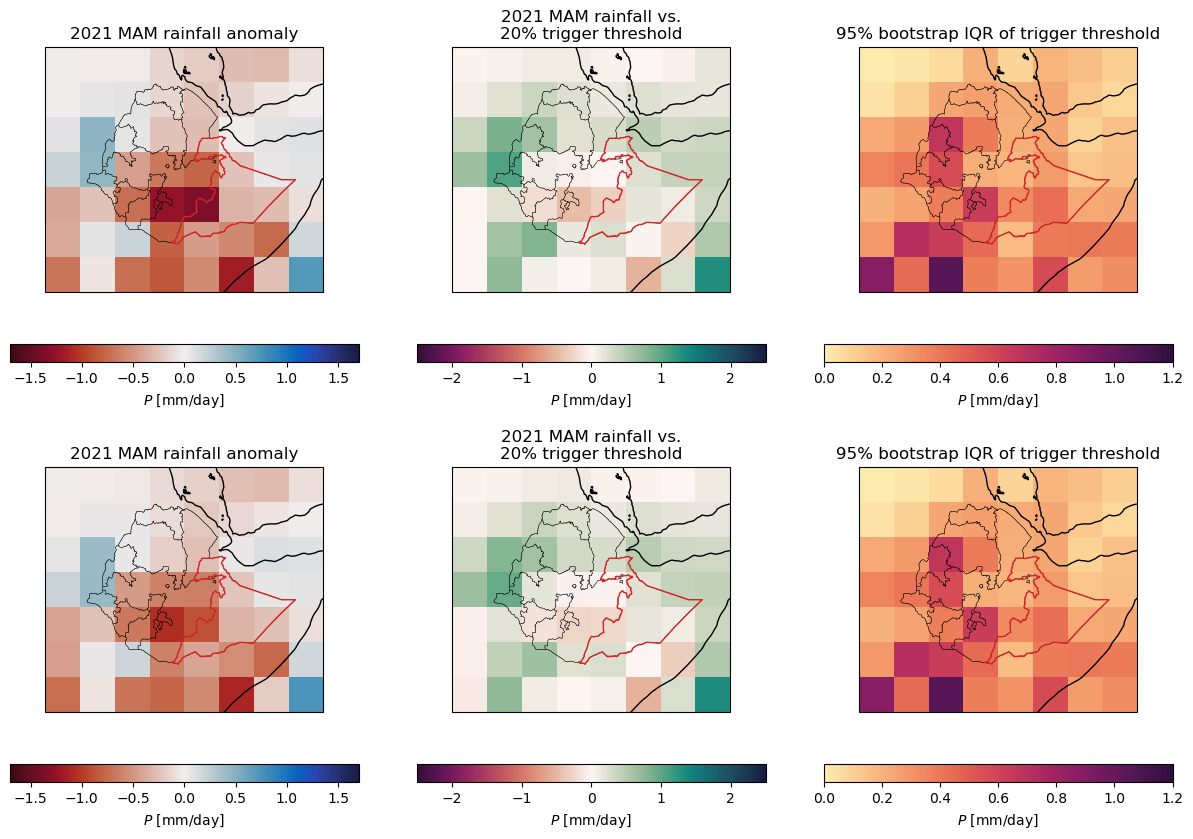

In [99]:
fig = plt.figure(figsize=(15,10))

gs = GridSpec(2, 6, wspace = 0.4)

#------------------------------------------------
# Maps
#------------------------------------------------
for row_idx,desc in enumerate(dsm.timesample.values):
    for plt_idx,var in enumerate(map_varlist):
        ax = fig.add_subplot(gs[row_idx,(plt_idx*2):((plt_idx+1)*2)],projection=ccrs.PlateCarree())
    
        # Plot variable
        plot_data = dsm.sel(**subset_params,season=proc_params['season'],timesample=desc)[var]
        if 'year' in plot_data.sizes:
            plot_data = plot_data.sel(year=test_year) 
        plot_data.plot(**cbar_params[var],transform=ccrs.PlateCarree())
    
        # Add borders
        for adm_code,weight in zip(['admin1','admin0'],[0.25,0.3]):
            gdfs[adm_code].cx[subset_params['lon'],subset_params['lat']].plot(ax=ax,facecolor='none',edgecolor='k',
                                                               linestyle='-',linewidth=weight,
                                                               transform=ccrs.PlateCarree(),
                                                                             )
        # Highlight Somali region
        gdfs['admin1'].query(f'adm1_name=="{proc_params['poly_idx']}"').plot(ax=ax,facecolor='none',edgecolor='tab:red',
                                                       linestyle='-',linewidth=1,
                                                       transform=ccrs.PlateCarree())
        
        # Add coastlines
        ax.coastlines()
    
        # Annotate
        ax.set_title(titles[var])